In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Fetch ETF data
etfs = ['IWD', 'IWN', 'IWM', 'EFA', 'EEM', 'IEF', 'LQD', 'TLT', 'DBC', 'GLD', 'VNQ']
#etfs = ['IWD', 'MTUM', 'IWN', 'IWM', 'EFA', 'EEM', 'IEF', 'BWX', 'LQD', 'TLT', 'DBC', 'GLD', 'VNQ']
start_date = '2006-03-31'
end_date = '2024-04-30'
data = yf.download(etfs, start=start_date, end=end_date)['Adj Close']

# Calculate monthly returns
monthly_data = data.resample('ME').last()
monthly_returns = monthly_data.pct_change().dropna()

[*********************100%%**********************]  11 of 11 completed


In [27]:
# Define a function to highlight NaN values
def highlight_nan(s):
    return ['background-color: red' if pd.isna(v) else '' for v in s]

# Check for missing data
display(monthly_data.style.apply(highlight_nan, axis=1))

Ticker,DBC,EEM,EFA,GLD,IEF,IWD,IWM,IWN,LQD,TLT,VNQ
Date,,,,,,,,,,,
2006-03-31 00:00:00,20.665064,22.958775,38.560043,58.099998,51.958576,48.216534,59.506191,52.436474,51.449341,49.885677,31.718443
2006-04-30 00:00:00,22.115244,24.454578,40.407261,65.089996,51.632744,49.317936,59.686359,52.611862,51.345337,48.512596,30.639690
2006-05-31 00:00:00,22.028923,21.729668,38.862961,64.230003,51.577572,48.117611,56.294743,50.507122,51.247768,48.419964,29.813105
2006-06-30 00:00:00,21.839018,21.776051,38.839199,61.230000,51.696037,48.358337,56.271214,50.929131,51.203709,48.990540,31.292124
2006-07-31 00:00:00,22.322414,22.286245,39.153988,63.160000,52.563148,49.518562,54.663006,50.316875,51.950748,50.050381,32.509827
2006-08-31 00:00:00,21.580059,22.638746,40.151852,62.290001,53.490097,50.267735,56.302559,51.780643,53.106995,51.579956,33.642578
2006-09-30 00:00:00,20.673697,22.441620,40.240944,59.470001,54.136021,51.367371,56.663830,52.158875,53.570316,52.567669,34.303955
2006-10-31 00:00:00,20.880863,24.025549,41.749619,60.240002,54.427570,52.953621,59.992809,54.888798,54.106709,53.012745,36.371731
2006-11-30 00:00:00,22.253355,25.463364,43.032566,64.389999,55.141342,54.193306,61.440907,56.310390,54.897453,54.236347,38.110748


In [16]:
monthly_returns

Ticker,DBC,EEM,EFA,GLD,IEF,IWD,IWM,IWN,LQD,TLT,VNQ
Date,,,,,,,,,,,
2007-02-28,0.050854,-0.032371,-0.001212,0.025451,0.020550,-0.014942,-0.006553,-0.012805,0.020004,0.033890,-0.026981
2007-03-31,0.006743,0.053345,0.028995,-0.011131,-0.001382,0.014353,0.009803,0.013347,-0.006750,-0.017003,-0.020749
2007-04-30,0.007486,0.037253,0.037484,0.020535,0.006065,0.036926,0.016237,0.006790,0.008915,0.009050,-0.001261
2007-05-31,-0.002347,0.050645,0.023623,-0.023103,-0.013935,0.035611,0.043720,0.039853,-0.012308,-0.023138,-0.003786
2007-06-30,0.007448,0.036783,-0.003209,-0.019378,-0.004676,-0.023189,-0.014383,-0.023831,-0.008099,-0.010135,-0.090077
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,-0.032913,0.035653,0.053510,0.012821,0.037723,0.055407,0.121262,0.124193,0.048753,0.086858,0.094453
2024-01-31,0.013158,-0.045262,-0.004512,-0.014228,0.000726,0.000605,-0.039011,-0.046289,-0.004428,-0.022451,-0.050589
2024-02-29,-0.015226,0.041678,0.029863,0.004564,-0.020826,0.035742,0.056253,0.032807,-0.019320,-0.022522,0.019788


In [17]:
def getIVP(cov):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov, cItems):
    cov_ = cov.loc[cItems, cItems]
    w_ = getIVP(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

def getQuasiDiag(link):
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)
        df0 = sortIx[sortIx >= numItems]
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0])
        sortIx = sortIx.sort_index()
        sortIx.index = range(sortIx.shape[0])
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    w = pd.Series(1.0, index=sortIx)  # Ensure the weights are of float dtype
    cItems = [sortIx]
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]
        for i in range(0, len(cItems), 2):
            cItems0 = cItems[i]
            cItems1 = cItems[i + 1]
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha
            w[cItems1] *= 1 - alpha
    return w

def getHRP(cov, corr):
    dist = correlDist(corr)
    dist = np.nan_to_num(dist)  # Replace non-finite values with 0
    dist_condensed = ssd.squareform(dist, checks=False)  # Convert to condensed distance matrix
    link = sch.linkage(dist_condensed, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

def correlDist(corr):
    dist = ((1 - corr) / 2.) ** 0.5
    return dist

In [18]:
# Initialize wealth Series with float dtype
initial_investment = 100.0
hrp_wealth = pd.Series(index=monthly_returns.index, data=initial_investment, dtype=float)
ew_wealth = pd.Series(index=monthly_returns.index, data=initial_investment, dtype=float)

# Minimum number of observations required to compute covariance and correlation matrices
min_obs = 2

# Backtest HRP and equally weighted strategies
for i in range(1, len(monthly_returns)):
    if i < min_obs:
        hrp_wealth.iloc[i] = hrp_wealth.iloc[i - 1]
        ew_wealth.iloc[i] = ew_wealth.iloc[i - 1]
        continue
    
    cov_matrix = monthly_returns.iloc[:i].cov()
    corr_matrix = monthly_returns.iloc[:i].corr()

    # Check for non-finite values and handle them
    if not np.isfinite(cov_matrix.values).all() or not np.isfinite(corr_matrix.values).all():
        print(f"Skipping period {monthly_returns.index[i]} due to non-finite values in covariance or correlation matrix.")
        hrp_wealth.iloc[i] = hrp_wealth.iloc[i - 1]
        ew_wealth.iloc[i] = ew_wealth.iloc[i - 1]
        continue

    hrp_weights = getHRP(cov_matrix, corr_matrix)
    ew_weights = np.ones(len(etfs)) / len(etfs)
    
    hrp_return = np.dot(monthly_returns.iloc[i], hrp_weights)
    ew_return = np.dot(monthly_returns.iloc[i], ew_weights)
    
    hrp_wealth.iloc[i] = hrp_wealth.iloc[i - 1] * (1 + hrp_return)
    ew_wealth.iloc[i] = ew_wealth.iloc[i - 1] * (1 + ew_return)


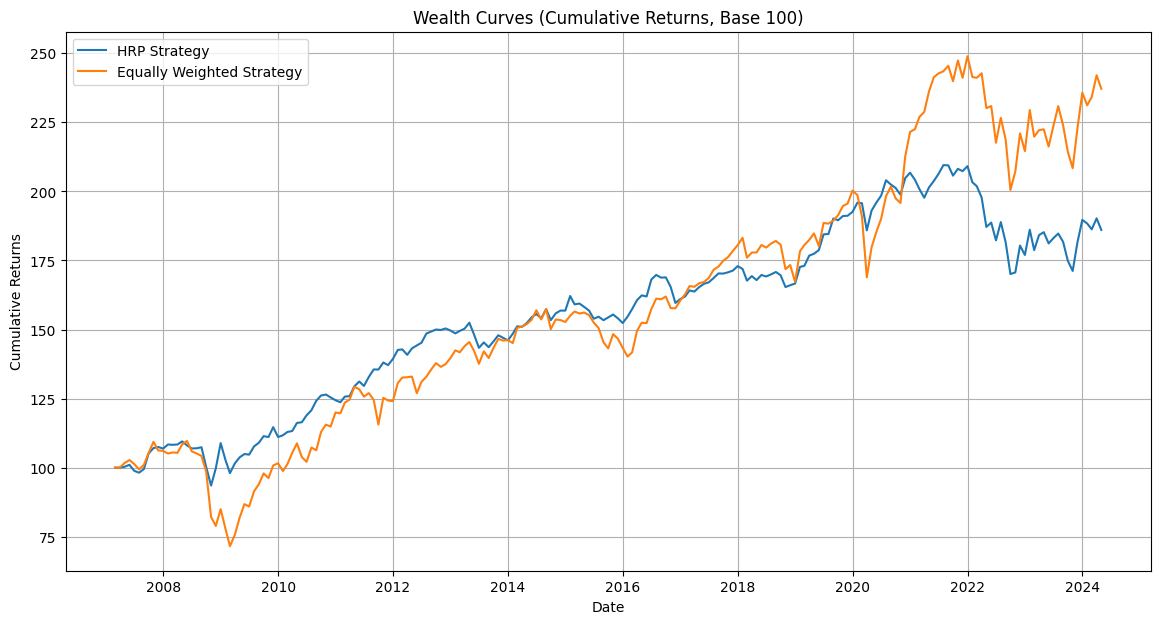

In [19]:
# Plot the wealth curves
plt.figure(figsize=(14, 7))
plt.plot(hrp_wealth, label='HRP Strategy')
plt.plot(ew_wealth, label='Equally Weighted Strategy')
plt.title('Wealth Curves (Cumulative Returns, Base 100)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

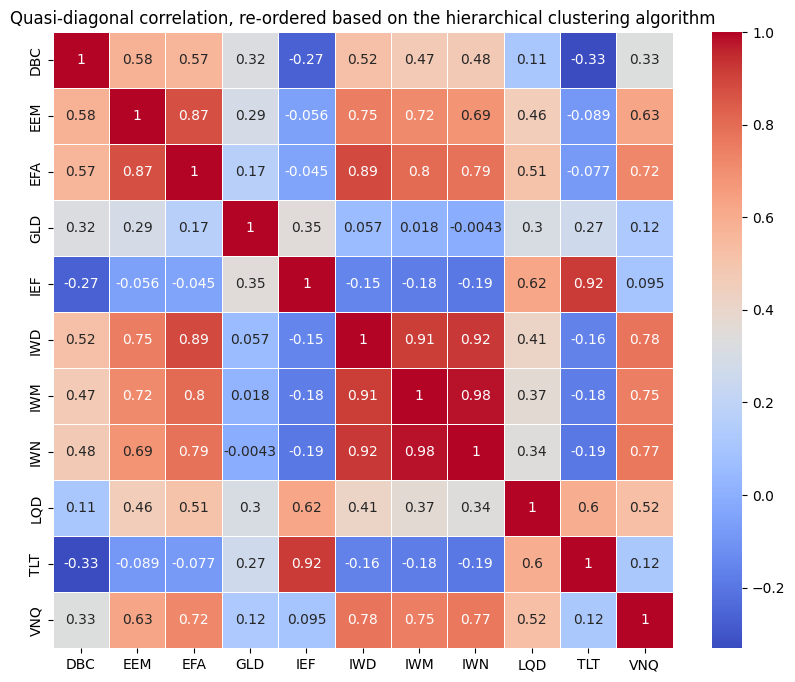

In [20]:
# Plot the heatmap of the reordered correlation matrix
cov_matrix = monthly_returns.cov()
corr_matrix = monthly_returns.corr()
sortIx = getHRP(cov_matrix, corr_matrix).index
sorted_corr_matrix = corr_matrix.loc[sortIx, sortIx]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Quasi-diagonal correlation, re-ordered based on the hierarchical clustering algorithm')
plt.show()

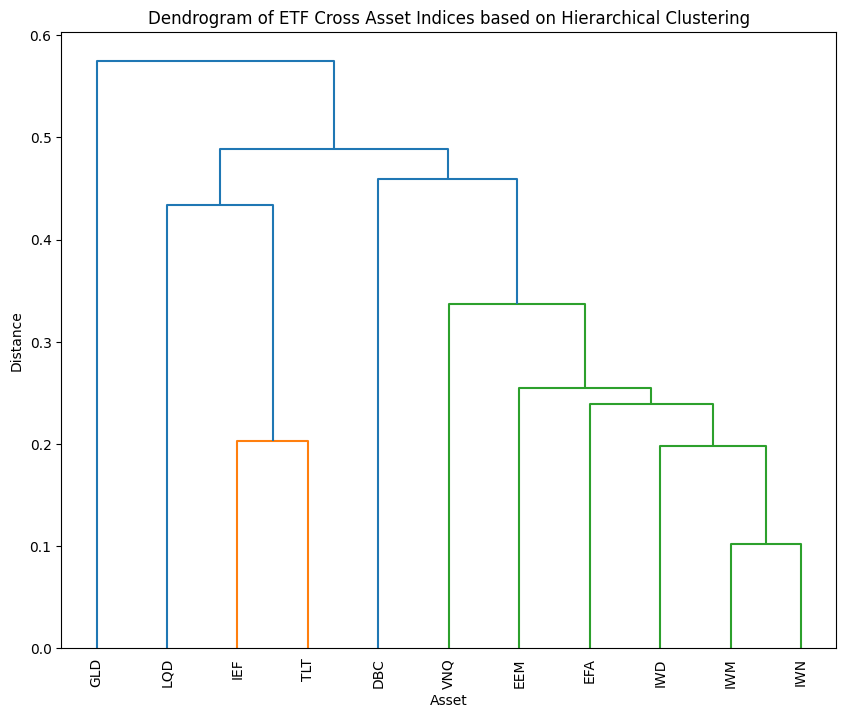

In [29]:
# Calculate the covariance and correlation matrices
cov_matrix = monthly_returns.cov()
corr_matrix = monthly_returns.corr()

# Calculate the distance matrix
dist_matrix = correlDist(corr_matrix)

# Convert the distance matrix to a condensed form
dist_condensed = ssd.squareform(dist_matrix, checks=False)

# Perform hierarchical clustering
linkage_matrix = sch.linkage(dist_condensed, 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendro = sch.dendrogram(linkage_matrix, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10, color_threshold=0.7*max(linkage_matrix[:, 2]))
plt.title("Dendrogram of Cross Asset Indices based on Hierarchical Clustering")
plt.xlabel("Asset")
plt.ylabel("Distance")
plt.show()
